<a href="https://colab.research.google.com/github/Mwangi-dan/mission_capstone/blob/main/Capstone_project_Early_gastric_cancer_detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing of libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import os

Importing data

In [ ]:
base_dir = ('/content/drive/MyDrive/kvasir-dataset/refined_model')

# Subset of Images
Since Keras is a very large dataset, I would want to use only a small portion of the dataset to train the model(s)

In [ ]:
data_fraction = 0.2

In [ ]:
# Data Generator for Kvasir Dataset
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Adjust split as needed
)

### Data augmentation
Images in the dataset have been augmented to look as below just to enhance the results a bit. However, the quality of image data on Kvasir dataset is good enough that it;s not so necessary to augment it further

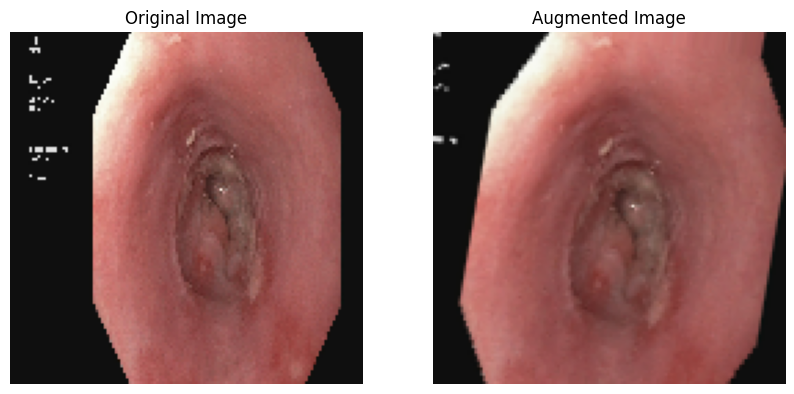

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Define the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=15,  # Small rotation angle to simulate slight misalignments
    width_shift_range=0.1,  # Small horizontal shift
    height_shift_range=0.1,  # Small vertical shift
    zoom_range=0.2,  # Simulate various distances
    horizontal_flip=True,  # Safe for many medical images
    fill_mode='nearest',  # To avoid empty pixels after shifts or rotations
    brightness_range=[0.8, 1.2],  # Adjust brightness slightly to simulate different lighting conditions
    shear_range=0.1,
)

# Load a sample image from your dataset
img_path = base_dir + '/cancerous/2f6b8639-58e4-4f3c-b651-42646de546f7.jpg'
img = load_img(img_path, target_size=(128, 128))  # Resize image to match the input size
img_array = img_to_array(img)  # Convert the image to a numpy array
img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match the format (batch_size, height, width, channels)

# Create an iterator to apply augmentations
augmented_img_iterator = datagen.flow(img_array, batch_size=1)

# Generate one augmented image
augmented_img = augmented_img_iterator.__next__()[0].astype('uint8') # Convert to uint8 for display

# Plot the original and augmented images side by side
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Augmented Image
plt.subplot(1, 2, 2)
plt.imshow(augmented_img)
plt.title('Augmented Image')
plt.axis('off')

# Show the images
plt.show()


# Vanilla CNN Model

Loading only a fraction of the training data

In [ ]:
# Load only a fraction of the training data
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

Found 137 images belonging to 2 classes.


## Validation generators
Loading a portion of the validation data

In [ ]:
validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=True,
    seed=42
)

Found 34 images belonging to 2 classes.


## Limiting the number of batches in each generator

In [ ]:
train_generator.samples = int(train_generator.samples * data_fraction)
validation_generator.samples = int(validation_generator.samples * data_fraction)

## Early stopping and model checkpoint callbacks

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)


# Model Implementation

In [ ]:
model = Sequential([
    # Convolutional layers with pooling
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    # Dense layers with dropout for regularization
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),

    # Output layer with softmax or sigmoid, depending on the problem
    Dense(1, activation='sigmoid')  # For binary classification
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)  # Binary classification
model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Compiling the model

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,312,961 (12.64 MB)

 Trainable params: 3,312,961 (12.64 MB)

 Non-trainable params: 0 (0.00 B)

## Training model

In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5090 - loss: 0.6946 - val_accuracy: 0.5000 - val_loss: 0.7006
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 873ms/step - accuracy: 0.4802 - loss: 0.7304 - val_accuracy: 0.7353 - val_loss: 0.6867
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6117 - loss: 0.6843 - val_accuracy: 0.7353 - val_loss: 0.6814
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 935ms/step - accuracy: 0.5480 - loss: 0.6852 - val_accuracy: 0.6176 - val_loss: 0.6755
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6304 - loss: 0.6632 - val_accuracy: 0.7059 - val_loss: 0.6499
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6225 - loss: 0.6160 - val_accuracy: 0.7059 - val_loss: 0.5943
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 881ms/step - accuracy: 0.6189 - loss: 0.6187 - val_accuracy: 0.7059 - val_loss: 0.5530
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6679 - loss: 0.6531 - val_accuracy: 0.7353 - val_loss: 0.6089
Epoch 9/10
5/5 

In [ ]:
class_weights = {0: 1.0, 1:1.7}  # Assign higher weight to the "cancerous" class
model.fit(train_generator, validation_data=validation_generator, class_weight=class_weights, epochs=10)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9156 - loss: 0.4121 - val_accuracy: 0.5000 - val_loss: 9.5143
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9005 - loss: 1.0813 - val_accuracy: 0.5000 - val_loss: 26.0047
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9481 - loss: 0.7057 - val_accuracy: 0.5000 - val_loss: 31.1289
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9188 - loss: 0.6296 - val_accuracy: 0.5000 - val_loss: 9.0954
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9322 - loss: 0.1530 - val_accuracy: 0.5000 - val_loss: 8.9367
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9188 - loss: 0.1822 - val_accuracy: 0.5000 - val_loss: 10.2181
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9233 - loss: 0.2565 - val_accuracy: 0.5000 - val_loss: 11.6518
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9862 - loss: 0.1265 - val_accuracy: 0.5000 - val_loss: 17.7555
Epo

# Model Evaluation

In [ ]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7598 - loss: 0.5295
Validation Accuracy: 0.76


In [ ]:
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7702 - loss: 0.5123 
Test Loss: 0.5284779071807861
Test Accuracy: 0.7647058963775635


# Visualizations

In [ ]:
import cv2
import tensorflow.keras.backend as K

## Validation & Loss Accuracy

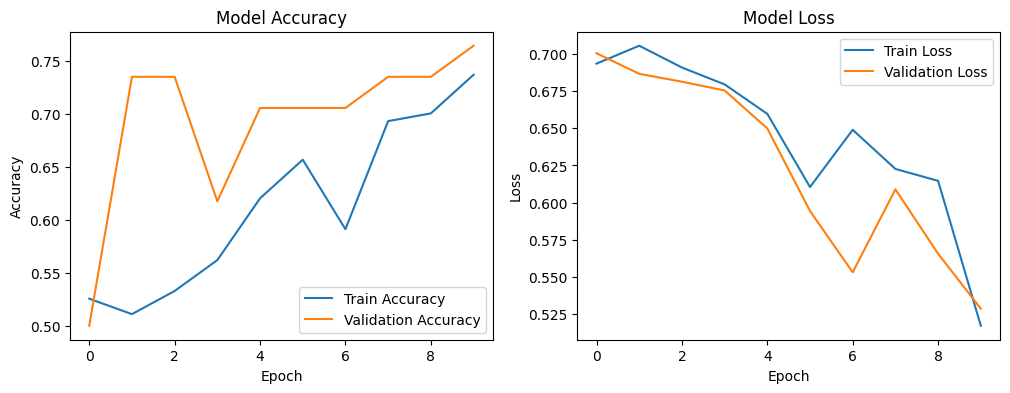

In [ ]:
# Plot accuracy and loss over epochs
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()


plot_training_history(history)

## Confusion Matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


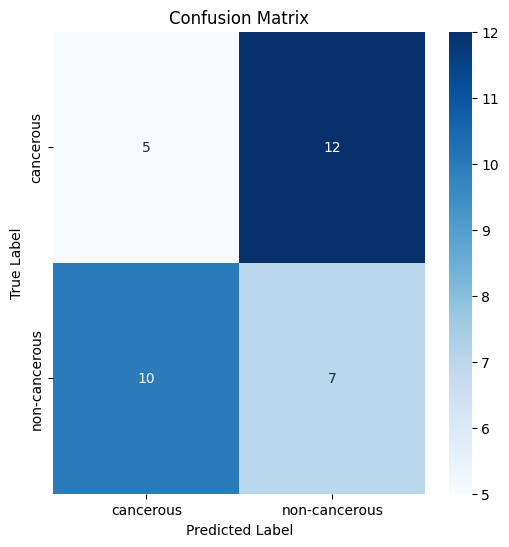

               precision    recall  f1-score   support

    cancerous       0.33      0.29      0.31        17
non-cancerous       0.37      0.41      0.39        17

     accuracy                           0.35        34
    macro avg       0.35      0.35      0.35        34
 weighted avg       0.35      0.35      0.35        34



In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions and convert probabilities to binary classes (0 or 1)
predictions = model.predict(validation_generator)
predicted_classes = (predictions > 0.5).astype("int32").flatten()
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification report for detailed metrics
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


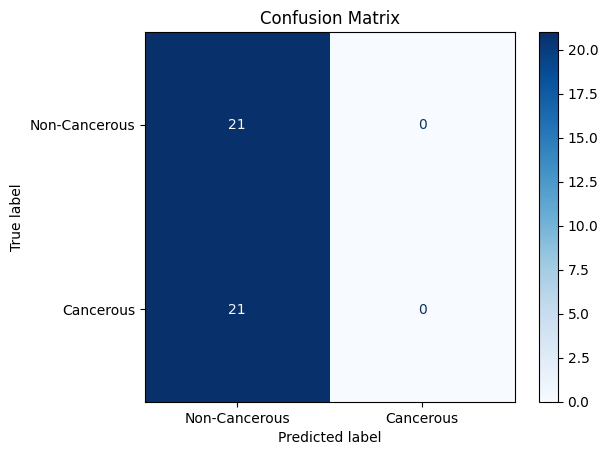

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions from the validation generator
# Assuming validation_generator is defined and contains validation data
y_true = validation_generator.classes  # True labels from the generator
y_pred_probs = model.predict(validation_generator)  # Predicted probabilities
y_pred = np.round(y_pred_probs).astype(int)  # Convert probabilities to class labels

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels (update according to your dataset)
class_labels = ['Non-Cancerous', 'Cancerous']

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


## Saving Model - CNN model

In [ ]:
model.save("refined_2.keras")

### Confirming integrity of model

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model("refined.keras")

test_loss, test_accuracy = loaded_model.evaluate(validation_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.6853 - loss: 0.6032
Test Loss: 0.6037769913673401
Test Accuracy: 0.6842105388641357
